<a href="https://colab.research.google.com/github/pkweber25/pkweber25.github.io/blob/main/capstone_ids.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# IDS Capstone


In [8]:

import os, random, json
DATA_DIR = '/content/data'

os.makedirs(DATA_DIR, exist_ok=True)
print('DATA_DIR =', DATA_DIR)

# !pip install -q pandas numpy scikit-learn tensorflow matplotlib seaborn joblib

import numpy as np, pandas as pd, joblib, matplotlib.pyplot as plt, seaborn as sns
sns.set(style='whitegrid')
import tensorflow as tf
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)
print('numpy', np.__version__, 'pandas', pd.__version__, 'tensorflow', tf.__version__)


DATA_DIR = /content/data
numpy 2.0.2 pandas 2.2.2 tensorflow 2.19.0


In [9]:

# Expected NSL-KDD file
NSL_CSV = os.path.join(DATA_DIR, 'KDDTrain+.csv')
print('Looking for NSL-KDD CSV at:', NSL_CSV)
print('Found?' , os.path.exists(NSL_CSV))
if not os.path.exists(NSL_CSV):
    print('\nIf your file has a different name, upload it to DATA_DIR or update NSL_CSV variable.\n')


Looking for NSL-KDD CSV at: /content/data/KDDTrain+.csv
Found? True


In [10]:

# Load NSL-KDD and normalize labels to binary 'label'
def try_load(path):
    if not os.path.exists(path):
        return None
    try:
        df = pd.read_csv(path)
    except Exception as e:
        df = pd.read_csv(path, header=None)
    return df

df = try_load(NSL_CSV)
if df is None:
    raise FileNotFoundError(f'NSL CSV not found at {NSL_CSV} - upload file and rerun')

print('Raw shape:', df.shape)
print('Sample columns:', df.columns.tolist()[:10])

# Normalize label column
def normalize_label(df, label_col=None):
    df = df.copy()
    if label_col and label_col in df.columns:
        df = df.rename(columns={label_col:'label'})
    elif 'label' not in df.columns:
        df = df.rename(columns={df.columns[-1]:'label'})
    def map_label(x):
        s = str(x).strip().lower()
        if s in ('normal','normal.','benign','benign.','0','no'):
            return 0
        if 'normal' in s or 'benign' in s:
            return 0
        return 1
    df['label'] = df['label'].apply(map_label)
    return df

df = normalize_label(df)
print('After normalization, sample label counts:')
print(df['label'].value_counts())
display(df.head())


Raw shape: (125972, 43)
Sample columns: ['0', 'tcp', 'ftp_data', 'SF', '491', '0.1', '0.2', '0.3', '0.4', '0.5']
After normalization, sample label counts:
label
1    125906
0        66
Name: count, dtype: int64


,0,tcp,ftp_data,SF,491,0.1,0.2,0.3,0.4,0.5,...,0.17,0.03,0.17.1,0.00.6,0.00.7,0.00.8,0.05,0.00.9,normal,label
0,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,1
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,1
2,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,1
3,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,1
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,1


In [11]:
# Preprocessing: feature selection, one-hot small-cardinality categorical, scaling.
cache_path = os.path.join(DATA_DIR, 'nsl_preprocessed.npz')
preprocessor_path = os.path.join(DATA_DIR, 'nsl_preprocessor.joblib')

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

def build_preprocessor(df, max_cardinality=30):
    cat_cols = [c for c in df.columns if df[c].dtype=='object' and c!='label']
    num_cols = [c for c in df.columns if c not in cat_cols + ['label']]

    for col in num_cols:
        if df[col].dtype == 'object':
            print(f"Converting column '{col}' to numeric.")
            df[col] = pd.to_numeric(df[col], errors='coerce')
            df[col] = df[col].fillna(0) # Simple imputation

    cat_small = [c for c in cat_cols if df[c].nunique()<=max_cardinality]
    cat_large = [c for c in cat_cols if df[c].nunique()>max_cardinality]

    transformer = ColumnTransformer(transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat_small', OneHotEncoder(handle_unknown='ignore'), cat_small)
        # ('cat_large', 'drop', cat_large) # Option to drop large cardinality categorical features
    ], remainder='drop')

    print(f"Identified numerical columns: {num_cols}")
    print(f"Identified small cardinality categorical columns: {cat_small}")
    print(f"Identified large cardinality categorical columns (will be dropped): {cat_large}")

    return transformer, num_cols, cat_small

if os.path.exists(cache_path):
    print('Loading preprocessed arrays from cache:', cache_path)
    data = np.load(cache_path, allow_pickle=True)
    X_train = data['X_train']
    X_val = data['X_val']
    y_train = data['y_train']
    y_val = data['y_val']
    print('Loaded shapes:', X_train.shape, X_val.shape)
    if os.path.exists(preprocessor_path):
        preprocessor = joblib.load(preprocessor_path)
        print('Loaded preprocessor from', preprocessor_path)
    else:
        preprocessor = None
else:
    print('No cache found — preprocessing now (this may take time).')
    transformer, num_cols, cat_small = build_preprocessor(df.copy()) # Pass a copy to avoid modifying the original df if cache exists later
    X = df.drop(columns=['label']).copy()
    y = df['label'].astype(int).values
    Xp = transformer.fit_transform(X)
    # train/val split (stratified)
    X_train, X_val, y_train, y_val = train_test_split(Xp, y, test_size=0.2, stratify=y, random_state=SEED)
    # save cache and preprocessor
    np.savez_compressed(cache_path, X_train=X_train, X_val=X_val, y_train=y_train, y_val=y_val)
    joblib.dump(transformer, preprocessor_path)
    preprocessor = transformer
    print('Saved preprocessed arrays to', cache_path)
    print('Shapes:', X_train.shape, X_val.shape)

No cache found — preprocessing now (this may take time).
Identified numerical columns: ['0', '491', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '0.10', '0.11', '0.12', '0.13', '0.14', '0.15', '0.16', '0.18', '2', '2.1', '0.00', '0.00.1', '0.00.2', '0.00.3', '1.00', '0.00.4', '0.00.5', '150', '25', '0.17', '0.03', '0.17.1', '0.00.6', '0.00.7', '0.00.8', '0.05', '0.00.9']
Identified small cardinality categorical columns: ['tcp', 'SF', 'normal']
Identified large cardinality categorical columns (will be dropped): ['ftp_data']
Saved preprocessed arrays to /content/data/nsl_preprocessed.npz
Shapes: (100777, 75) (25195, 75)


In [12]:

print('Train class distribution:', np.bincount(y_train))
print('Val class distribution:', np.bincount(y_val))
print('Feature dimension after preprocessing:', X_train.shape[1])


Train class distribution: [    53 100724]
Val class distribution: [   13 25182]
Feature dimension after preprocessing: 75


In [13]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

def train_rf(X_tr, y_tr, X_val, y_val, n_estimators=200):
    rf = RandomForestClassifier(n_estimators=n_estimators, n_jobs=-1, random_state=SEED)
    rf.fit(X_tr, y_tr)
    y_pred = rf.predict(X_val)
    y_prob = rf.predict_proba(X_val)[:,1] if hasattr(rf,'predict_proba') else None
    print('RF Validation report:')
    print(classification_report(y_val, y_pred, digits=4))
    if y_prob is not None:
        print('ROC-AUC:', round(roc_auc_score(y_val, y_prob),4))
    return rf, y_pred, y_prob

rf, rf_val_pred, rf_val_prob = train_rf(X_train, y_train, X_val, y_val, n_estimators=100)
joblib.dump(rf, os.path.join(DATA_DIR,'rf_nsl_baseline.joblib'))


RF Validation report:
              precision    recall  f1-score   support

           0     0.7000    0.5385    0.6087        13
           1     0.9998    0.9999    0.9998     25182

    accuracy                         0.9996     25195
   macro avg     0.8499    0.7692    0.8043     25195
weighted avg     0.9996    0.9996    0.9996     25195

ROC-AUC: 0.9998


['/content/data/rf_nsl_baseline.joblib']

Training AE on normal-only training data (this may take a few minutes).
Epoch 1/50
1/1 - 2s - 2s/step - loss: 1.3183 - val_loss: 9.5186
Epoch 2/50
1/1 - 0s - 101ms/step - loss: 1.2875 - val_loss: 9.3564
Epoch 3/50
1/1 - 0s - 90ms/step - loss: 1.2645 - val_loss: 9.2689
Epoch 4/50
1/1 - 0s - 93ms/step - loss: 1.2487 - val_loss: 9.1952
Epoch 5/50
1/1 - 0s - 116ms/step - loss: 1.2347 - val_loss: 9.1086
Epoch 6/50
1/1 - 0s - 98ms/step - loss: 1.2203 - val_loss: 9.0134
Epoch 7/50
1/1 - 0s - 93ms/step - loss: 1.2042 - val_loss: 8.9111
Epoch 8/50
1/1 - 0s - 91ms/step - loss: 1.1862 - val_loss: 8.7897
Epoch 9/50
1/1 - 0s - 93ms/step - loss: 1.1668 - val_loss: 8.6497
Epoch 10/50
1/1 - 0s - 94ms/step - loss: 1.1452 - val_loss: 8.4922
Epoch 11/50
1/1 - 0s - 101ms/step - loss: 1.1215 - val_loss: 8.3066
Epoch 12/50
1/1 - 0s - 94ms/step - loss: 1.0950 - val_loss: 8.1033
Epoch 13/50
1/1 - 0s - 95ms/step - loss: 1.0665 - val_loss: 7.8813
Epoch 14/50
1/1 - 0s - 93ms/step - loss: 1.0357 - val_loss: 7.639

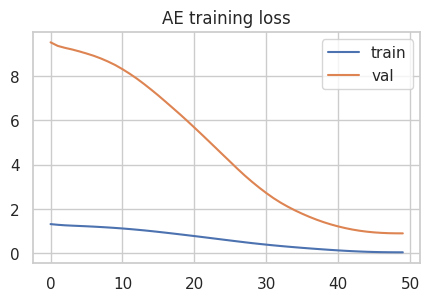

In [14]:

from tensorflow.keras import layers, models, callbacks
ae_path = os.path.join(DATA_DIR, 'ae_nsl.h5')
encoder_path = os.path.join(DATA_DIR, 'encoder_nsl.h5')

def build_ae(input_dim, latent_dim=32):
    inp = layers.Input(shape=(input_dim,))
    x = layers.Dense(128, activation='relu')(inp)
    x = layers.Dense(64, activation='relu')(x)
    latent = layers.Dense(latent_dim, activation='relu', name='latent')(x)
    x = layers.Dense(64, activation='relu')(latent)
    x = layers.Dense(128, activation='relu')(x)
    out = layers.Dense(input_dim, activation='linear')(x)
    ae = models.Model(inputs=inp, outputs=out)
    ae.compile(optimizer='adam', loss='mse')
    return ae

if os.path.exists(ae_path) and os.path.exists(encoder_path):
    print('Loading AE and encoder from disk.')
    ae = models.load_model(ae_path)
    encoder = models.load_model(encoder_path)
else:
    print('Training AE on normal-only training data')
    ae = build_ae(X_train.shape[1], latent_dim=32)
    X_ae_tr = X_train[y_train==0]
    X_ae_val = X_val[y_val==0]
    cb = [callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
    history = ae.fit(X_ae_tr, X_ae_tr, validation_data=(X_ae_val, X_ae_val), epochs=50, batch_size=256, callbacks=cb, verbose=2)
    ae.save(ae_path)
    encoder = models.Model(inputs=ae.input, outputs=ae.get_layer('latent').output)
    encoder.save(encoder_path)
    # plot training curve
    plt.figure(figsize=(5,3)); plt.plot(history.history['loss'], label='train'); plt.plot(history.history['val_loss'], label='val'); plt.title('AE training loss'); plt.legend(); plt.show()


In [15]:

# Compute AE reconstruction error on validation and set threshold (95th percentile on normal val)
recon = np.mean((ae.predict(X_val) - X_val)**2, axis=1)
recon_normal = recon[y_val==0]
ae_threshold = float(np.percentile(recon_normal, 95))
print('AE threshold (95th percentile on normal val):', ae_threshold)


788/788 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
AE threshold (95th percentile on normal val): 4.53884756738975


In [16]:

def hybrid_predict(X, rf, ae, rf_thresh=0.5, ae_thresh=None):
    probs = rf.predict_proba(X)[:,1]
    rf_pred = (probs >= rf_thresh).astype(int)
    recon = np.mean((ae.predict(X) - X)**2, axis=1)
    if ae_thresh is None:
        ae_thresh = float(np.percentile(recon,95))
    hybrid = rf_pred.copy()
    mask = (rf_pred==1) & (recon < ae_thresh)
    hybrid[mask] = 0
    return hybrid, probs, recon

hybrid_pred, hybrid_probs, hybrid_recon = hybrid_predict(X_val, rf, ae, rf_thresh=0.5, ae_thresh=ae_threshold)
from sklearn.metrics import classification_report, roc_auc_score
print('Hybrid RF+AE Validation report:')
print(classification_report(y_val, hybrid_pred, digits=4))
print('RF prob ROC-AUC:', round(roc_auc_score(y_val, hybrid_probs),4))


788/788 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Hybrid RF+AE Validation report:
              precision    recall  f1-score   support

           0     0.0005    0.9231    0.0010        13
           1     0.9848    0.0026    0.0051     25182

    accuracy                         0.0031     25195
   macro avg     0.4927    0.4628    0.0031     25195
weighted avg     0.9843    0.0031    0.0051     25195

RF prob ROC-AUC: 0.9998


In [17]:

from sklearn.decomposition import PCA
pca_rf_path = os.path.join(DATA_DIR, 'pca_ae_rf.joblib')
if os.path.exists(pca_rf_path):
    print('Loaded PCA+RF model from disk.')
    obj = joblib.load(pca_rf_path)
    pca = obj['pca']; rf_comb = obj['rf']
else:
    print('Fitting PCA on training set and concatenating AE latent features.')
    pca = PCA(n_components=0.95, random_state=SEED)
    X_tr_pca = pca.fit_transform(X_train)
    X_val_pca = pca.transform(X_val)
    X_tr_ae = encoder.predict(X_train)
    X_val_ae = encoder.predict(X_val)
    X_tr_comb = np.hstack([X_tr_pca, X_tr_ae])
    X_val_comb = np.hstack([X_val_pca, X_val_ae])
    rf_comb = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=SEED)
    rf_comb.fit(X_tr_comb, y_train)
    y_val_comb = rf_comb.predict(X_val_comb)
    print('RF on PCA+AE features report:')
    print(classification_report(y_val, y_val_comb, digits=4))
    joblib.dump({'pca':pca, 'rf':rf_comb}, pca_rf_path)


Fitting PCA on training set and concatenating AE latent features.
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
788/788 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
RF on PCA+AE features report:
              precision    recall  f1-score   support

           0     0.7143    0.3846    0.5000        13
           1     0.9997    0.9999    0.9998     25182

    accuracy                         0.9996     25195
   macro avg     0.8570    0.6923    0.7499     25195
weighted avg     0.9995    0.9996    0.9995     25195



In [18]:

# Simple rolling-window aggregate features on processed arrays to approximate temporal context
def rolling_stats_numpy(X, window=5):
    n = X.shape[0]
    mean_feat = np.zeros((n,1))
    var_feat = np.zeros((n,1))
    for i in range(n):
        start = max(0, i-window+1)
        block = X[start:i+1]
        mean_feat[i,0] = block.mean()
        var_feat[i,0] = block.var()
    return mean_feat, var_feat

mm_tr, vv_tr = rolling_stats_numpy(X_train, window=5)
mm_val, vv_val = rolling_stats_numpy(X_val, window=5)
X_tr_time = np.hstack([X_train, mm_tr, vv_tr])
X_val_time = np.hstack([X_val, mm_val, vv_val])

rf_time = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=SEED)
rf_time.fit(X_tr_time, y_train)
y_time_pred = rf_time.predict(X_val_time)
print('RF with temporal aggregates report:')
print(classification_report(y_val, y_time_pred, digits=4))


RF with temporal aggregates report:
              precision    recall  f1-score   support

           0     0.8750    0.5385    0.6667        13
           1     0.9998    1.0000    0.9999     25182

    accuracy                         0.9997     25195
   macro avg     0.9374    0.7692    0.8333     25195
weighted avg     0.9997    0.9997    0.9997     25195



Saved experiment results to /content/data/nsl_experiment_results.csv


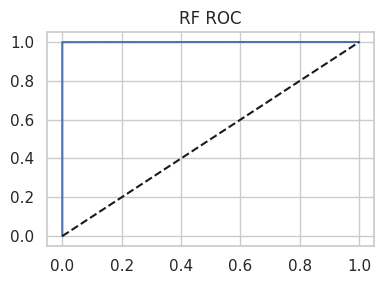

<Figure size 400x300 with 0 Axes>

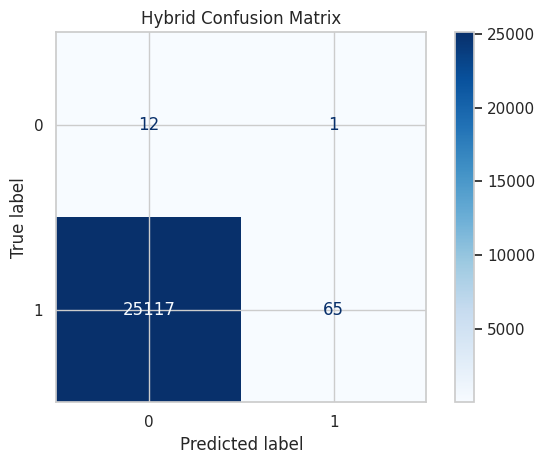

Artifacts saved to /content/data/artifacts


In [19]:

# Log basic experiment metrics and save artifacts (plots + csv)
import csv, datetime
results = []

def summarize(y_true, y_pred):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    return {'accuracy': float(accuracy_score(y_true, y_pred)),
            'precision': float(precision_score(y_true, y_pred, zero_division=0)),
            'recall': float(recall_score(y_true, y_pred, zero_division=0)),
            'f1': float(f1_score(y_true, y_pred, zero_division=0))}

# collect metrics
results.append({'name':'RF_baseline', **summarize(y_val, rf_val_pred)})
results.append({'name':'RF_AE_hybrid', **summarize(y_val, hybrid_pred)})
if 'y_val_comb' in globals(): results.append({'name':'RF_PCA_AE', **summarize(y_val, y_val_comb)})
results.append({'name':'RF_temporal', **summarize(y_val, y_time_pred)})

out_csv = os.path.join(DATA_DIR, 'nsl_experiment_results.csv')
keys = results[0].keys()
with open(out_csv, 'w', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=keys)
    writer.writeheader()
    writer.writerows(results)
print('Saved experiment results to', out_csv)

# Save ROC and confusion matrix artifacts
artifact_dir = os.path.join(DATA_DIR, 'artifacts'); os.makedirs(artifact_dir, exist_ok=True)
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay
# RF ROC
fpr, tpr, _ = roc_curve(y_val, rf_val_prob)
plt.figure(figsize=(4,3)); plt.plot(fpr,tpr,label=f'RF AUC={auc(fpr,tpr):.3f}'); plt.plot([0,1],[0,1],'k--'); plt.title('RF ROC'); plt.tight_layout(); plt.savefig(os.path.join(artifact_dir,'roc_rf.png'), dpi=150); plt.show()
# Hybrid confusion matrix
plt.figure(figsize=(4,3)); ConfusionMatrixDisplay.from_predictions(y_val, hybrid_pred, cmap='Blues', values_format='d'); plt.title('Hybrid Confusion Matrix'); plt.tight_layout(); plt.savefig(os.path.join(artifact_dir,'cm_hybrid.png'), dpi=150); plt.show()

# Save models
joblib.dump(rf, os.path.join(artifact_dir,'rf_baseline.joblib'))
ae.save(os.path.join(artifact_dir,'ae_nsl.h5'))
joblib.dump({'pca':pca, 'rf_comb':rf_comb} if 'pca' in globals() else {'note':'no_pca'}, os.path.join(artifact_dir,'pca_rf.joblib'))

print('Artifacts saved to', artifact_dir)
